# Face Generation
In this project, we use generative adversarial networks (GANs) to generate new images of faces.
### Get the Data
Using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '~/data'
# note: use full path on computer (not just ~)
data_dir = '/home/thojo/work/ud/deep-learning/face_generation/data'

import helper
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

In [2]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """


# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

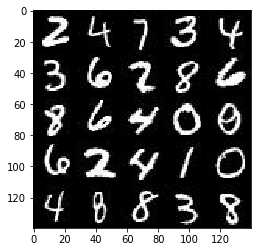

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

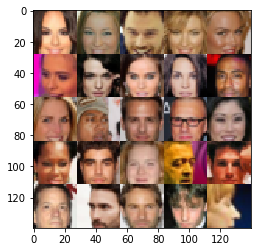

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim ):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2, keep_prob = 0.7):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # done: implement function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 28x28x1 for MNIST and celebA
            
            x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer()) 
            # no batch_normalization in the first layer
            lrelu1 = tf.maximum( alpha*x1, x1)
            lrelu1 = tf.nn.dropout(lrelu1, keep_prob)
            # now 14x14x64

            x2 = tf.layers.conv2d(lrelu1, 128, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
            bn2 = tf.layers.batch_normalization( x2, training = True )
            lrelu2 = tf.maximum( alpha*bn2, bn2)
            lrelu2 = tf.nn.dropout(lrelu2, keep_prob)
            # now 7x7x128

            x3 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
            bn3 = tf.layers.batch_normalization( x3, training = True )
            lrelu3 = tf.maximum( alpha*bn3, bn3)
            lrelu3 = tf.nn.dropout(lrelu3, keep_prob)
            # now 4x4x256

            flat = tf.reshape( lrelu3,(-1,4*4*256) ) 
            logits = tf.layers.dense( flat, 1 )
            out = tf.sigmoid( logits )

            return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use the retry module or similar alternatives.
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
### This was my first generator.  Keeping it here for reference.  Please see next cell where I have added an extra layer.
# def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
#     """
#     Create the generator network
#     :param z: Input z
#     :param out_channel_dim: The number of channels in the output image
#     :param is_train: Boolean if generator is being used for training
#     :return: The tensor output of the generator
#     """
#     with tf.variable_scope("generator", reuse=not is_train):   
#         # Fully connected
#         x1 = tf.layers.dense(z, 2*2*256, kernel_initializer=tf.contrib.layers.xavier_initializer())
#         # Reshape first layer as 2x2x256
#         x1 = tf.reshape(x1, (-1, 2, 2, 256))
#         x1 = tf.layers.batch_normalization(x1, training=True)
#         x1 = tf.maximum( alpha*x1, x1) #leaky relu

#         # Second layer as (7x7x128)
#         x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID', kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
#         # Third layer as (14x14x64)
#         x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum( alpha*x3, x3) #leaky relu

#         # Ouput layer as (28x28x out_channel_dim)
#         logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
#         out = tf.tanh(logits)

#     return out

# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# tests.test_generator(generator, tf)

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):   
        # Note: Based on reviewer's suggestion, adding an extra layer compared to the discriminator (4 vs 3) to make the generator stronger
        # Fully connected
        x1 = tf.layers.dense(z, 2*2*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape first layer as 2x2x512
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum( alpha*x1, x1) #leaky relu
        # Don't want to add dropout in this 2x2 layer

        # Second layer as (4x4x256)
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum( alpha*x2, x2) #leaky relu
        x2 = tf.nn.dropout(x2, keep_prob)
        
        # Second layer as (7x7x128)
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='VALID', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum( alpha*x3, x3) #leaky relu
        x3 = tf.nn.dropout(x3, keep_prob)
        
        # Third layer as (14x14x64)
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum( alpha*x4, x4) #leaky relu
        x4 = tf.nn.dropout(x4, keep_prob)

        # Ouput layer as (28x28x out_channel_dim)
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1 #For one-sided label smoothing (to prevent the discriminator from becoming too strong) 
    g_model = generator(input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real, reuse = False )
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1-smooth)*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, controlling dependencies approporiately
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode, print_every=100, show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1 )
 
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_num = 0
        for epoch_i in range(epoch_count):
            # Train Model
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 #rescaling to match the (-1,1) range of the tanh outputs from the generator
                steps += 1
                batch_num += 1
                # Sample random noise for G 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run( d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run( g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar })
                    train_loss_g = g_loss.eval({ input_z: batch_z, learning_rate: learning_rate_scalar})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch # {}/{}...".format(batch_num, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch # 100/1... Discriminator Loss: 1.3433... Generator Loss: 0.8317
Epoch 1/2... Batch # 200/1... Discriminator Loss: 1.1771... Generator Loss: 1.0231
Epoch 1/2... Batch # 300/1... Discriminator Loss: 1.1686... Generator Loss: 1.0791
Epoch 1/2... Batch # 400/1... Discriminator Loss: 1.1522... Generator Loss: 1.0102
Epoch 1/2... Batch # 500/1... Discriminator Loss: 1.0922... Generator Loss: 1.1399


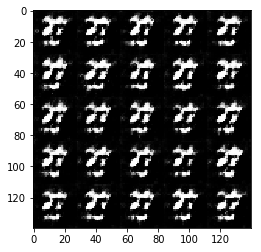

Epoch 1/2... Batch # 600/1... Discriminator Loss: 1.0421... Generator Loss: 1.1336
Epoch 1/2... Batch # 700/1... Discriminator Loss: 1.0727... Generator Loss: 1.0936
Epoch 1/2... Batch # 800/1... Discriminator Loss: 1.0570... Generator Loss: 1.1360
Epoch 1/2... Batch # 900/1... Discriminator Loss: 0.9189... Generator Loss: 1.3599
Epoch 1/2... Batch # 1000/1... Discriminator Loss: 1.1058... Generator Loss: 1.1292


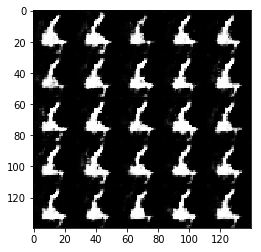

Epoch 1/2... Batch # 1100/1... Discriminator Loss: 0.9065... Generator Loss: 1.4633
Epoch 1/2... Batch # 1200/1... Discriminator Loss: 0.9588... Generator Loss: 1.4523
Epoch 1/2... Batch # 1300/1... Discriminator Loss: 0.9042... Generator Loss: 1.3201
Epoch 1/2... Batch # 1400/1... Discriminator Loss: 1.1397... Generator Loss: 1.1809
Epoch 1/2... Batch # 1500/1... Discriminator Loss: 0.9242... Generator Loss: 1.2775


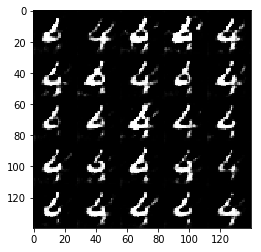

Epoch 1/2... Batch # 1600/1... Discriminator Loss: 0.8845... Generator Loss: 1.5021
Epoch 1/2... Batch # 1700/1... Discriminator Loss: 0.9577... Generator Loss: 1.5055
Epoch 1/2... Batch # 1800/1... Discriminator Loss: 1.0847... Generator Loss: 1.2104
Epoch 2/2... Batch # 1900/2... Discriminator Loss: 1.0390... Generator Loss: 1.2232
Epoch 2/2... Batch # 2000/2... Discriminator Loss: 1.0531... Generator Loss: 1.2702


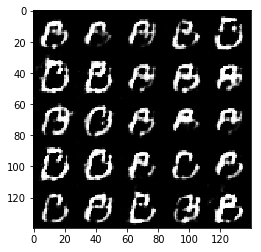

Epoch 2/2... Batch # 2100/2... Discriminator Loss: 1.2017... Generator Loss: 1.0497
Epoch 2/2... Batch # 2200/2... Discriminator Loss: 1.1105... Generator Loss: 1.1600
Epoch 2/2... Batch # 2300/2... Discriminator Loss: 1.0495... Generator Loss: 1.3027
Epoch 2/2... Batch # 2400/2... Discriminator Loss: 1.0885... Generator Loss: 1.2327
Epoch 2/2... Batch # 2500/2... Discriminator Loss: 1.1289... Generator Loss: 1.2176


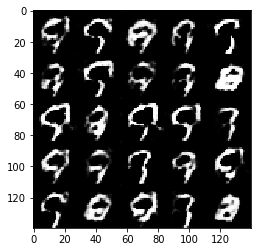

Epoch 2/2... Batch # 2600/2... Discriminator Loss: 1.1939... Generator Loss: 1.0434
Epoch 2/2... Batch # 2700/2... Discriminator Loss: 1.1520... Generator Loss: 1.1106
Epoch 2/2... Batch # 2800/2... Discriminator Loss: 1.2326... Generator Loss: 1.1023
Epoch 2/2... Batch # 2900/2... Discriminator Loss: 1.1323... Generator Loss: 1.2367
Epoch 2/2... Batch # 3000/2... Discriminator Loss: 1.2094... Generator Loss: 1.2182


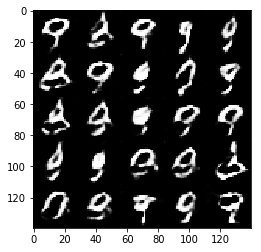

Epoch 2/2... Batch # 3100/2... Discriminator Loss: 1.1671... Generator Loss: 1.0999
Epoch 2/2... Batch # 3200/2... Discriminator Loss: 1.2683... Generator Loss: 1.1512
Epoch 2/2... Batch # 3300/2... Discriminator Loss: 1.2424... Generator Loss: 0.9846
Epoch 2/2... Batch # 3400/2... Discriminator Loss: 1.1641... Generator Loss: 1.1609
Epoch 2/2... Batch # 3500/2... Discriminator Loss: 1.2767... Generator Loss: 1.2170


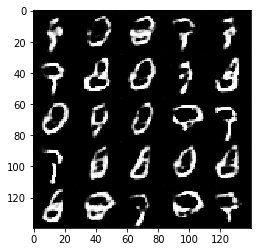

Epoch 2/2... Batch # 3600/2... Discriminator Loss: 1.1466... Generator Loss: 0.9896
Epoch 2/2... Batch # 3700/2... Discriminator Loss: 1.1890... Generator Loss: 1.1683


In [14]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode, print_every, show_every)

__Project notes for MNIST:__ With batch_size of 32, we can use slightly larger learning rates (0.0005) and get d_loss of 1.17 with g_loss of 0.76 (without dropout, Xavier init).   Whereas with batches of 16 and a learning rate of 0.0003, we only get to d_loss of 1.2883 and g_loss of 0.97. But these are training losses, so take with a pinch of salt.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch # 100/1... Discriminator Loss: 1.0717... Generator Loss: 1.3928
Epoch 1/1... Batch # 200/1... Discriminator Loss: 0.6674... Generator Loss: 1.8938
Epoch 1/1... Batch # 300/1... Discriminator Loss: 0.9005... Generator Loss: 2.1015
Epoch 1/1... Batch # 400/1... Discriminator Loss: 0.9236... Generator Loss: 1.3579
Epoch 1/1... Batch # 500/1... Discriminator Loss: 0.9485... Generator Loss: 1.4267


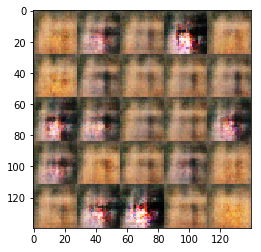

Epoch 1/1... Batch # 600/1... Discriminator Loss: 0.9018... Generator Loss: 1.2774
Epoch 1/1... Batch # 700/1... Discriminator Loss: 1.0346... Generator Loss: 1.2006
Epoch 1/1... Batch # 800/1... Discriminator Loss: 1.0851... Generator Loss: 1.1637
Epoch 1/1... Batch # 900/1... Discriminator Loss: 1.2722... Generator Loss: 0.9474
Epoch 1/1... Batch # 1000/1... Discriminator Loss: 1.1618... Generator Loss: 1.1364


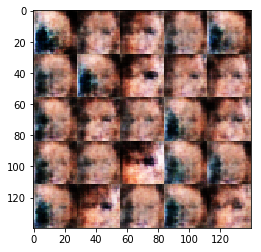

Epoch 1/1... Batch # 1100/1... Discriminator Loss: 1.1512... Generator Loss: 1.0162
Epoch 1/1... Batch # 1200/1... Discriminator Loss: 1.1028... Generator Loss: 1.0866
Epoch 1/1... Batch # 1300/1... Discriminator Loss: 1.2256... Generator Loss: 1.1401
Epoch 1/1... Batch # 1400/1... Discriminator Loss: 1.0934... Generator Loss: 1.1093
Epoch 1/1... Batch # 1500/1... Discriminator Loss: 1.1172... Generator Loss: 1.2234


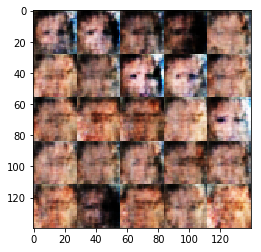

Epoch 1/1... Batch # 1600/1... Discriminator Loss: 1.3012... Generator Loss: 1.1939
Epoch 1/1... Batch # 1700/1... Discriminator Loss: 1.1356... Generator Loss: 0.9118
Epoch 1/1... Batch # 1800/1... Discriminator Loss: 1.1972... Generator Loss: 0.9922
Epoch 1/1... Batch # 1900/1... Discriminator Loss: 1.1803... Generator Loss: 1.1251
Epoch 1/1... Batch # 2000/1... Discriminator Loss: 1.1543... Generator Loss: 1.0711


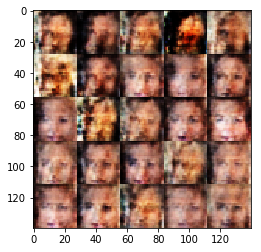

Epoch 1/1... Batch # 2100/1... Discriminator Loss: 1.2320... Generator Loss: 1.0647
Epoch 1/1... Batch # 2200/1... Discriminator Loss: 1.1617... Generator Loss: 1.0913
Epoch 1/1... Batch # 2300/1... Discriminator Loss: 1.1369... Generator Loss: 1.0840
Epoch 1/1... Batch # 2400/1... Discriminator Loss: 1.1631... Generator Loss: 1.0901
Epoch 1/1... Batch # 2500/1... Discriminator Loss: 1.2332... Generator Loss: 1.0606


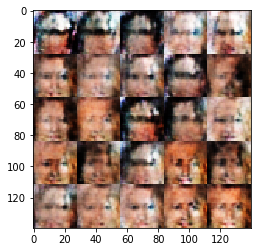

Epoch 1/1... Batch # 2600/1... Discriminator Loss: 1.1451... Generator Loss: 1.2104
Epoch 1/1... Batch # 2700/1... Discriminator Loss: 1.1917... Generator Loss: 1.0831
Epoch 1/1... Batch # 2800/1... Discriminator Loss: 1.1533... Generator Loss: 1.0977
Epoch 1/1... Batch # 2900/1... Discriminator Loss: 1.1507... Generator Loss: 1.0712
Epoch 1/1... Batch # 3000/1... Discriminator Loss: 1.1950... Generator Loss: 1.1022


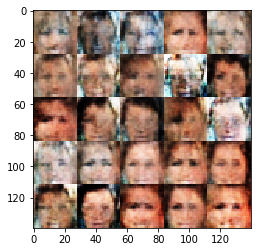

Epoch 1/1... Batch # 3100/1... Discriminator Loss: 1.2487... Generator Loss: 1.0593
Epoch 1/1... Batch # 3200/1... Discriminator Loss: 1.0671... Generator Loss: 1.1069
Epoch 1/1... Batch # 3300/1... Discriminator Loss: 1.2067... Generator Loss: 1.1008
Epoch 1/1... Batch # 3400/1... Discriminator Loss: 1.1311... Generator Loss: 1.2581
Epoch 1/1... Batch # 3500/1... Discriminator Loss: 1.0687... Generator Loss: 1.1558


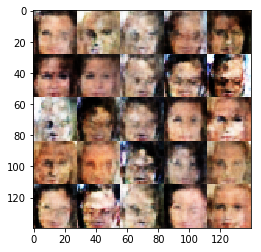

Epoch 1/1... Batch # 3600/1... Discriminator Loss: 1.1780... Generator Loss: 1.1089
Epoch 1/1... Batch # 3700/1... Discriminator Loss: 1.1398... Generator Loss: 0.9598
Epoch 1/1... Batch # 3800/1... Discriminator Loss: 1.2915... Generator Loss: 0.7630
Epoch 1/1... Batch # 3900/1... Discriminator Loss: 1.2260... Generator Loss: 1.0322
Epoch 1/1... Batch # 4000/1... Discriminator Loss: 1.1653... Generator Loss: 0.9652


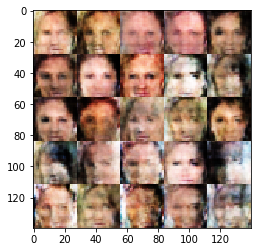

Epoch 1/1... Batch # 4100/1... Discriminator Loss: 1.1278... Generator Loss: 1.0723
Epoch 1/1... Batch # 4200/1... Discriminator Loss: 1.2476... Generator Loss: 1.0706
Epoch 1/1... Batch # 4300/1... Discriminator Loss: 1.1783... Generator Loss: 1.1081
Epoch 1/1... Batch # 4400/1... Discriminator Loss: 1.2164... Generator Loss: 1.0098
Epoch 1/1... Batch # 4500/1... Discriminator Loss: 1.2089... Generator Loss: 0.9525


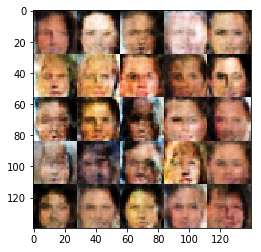

Epoch 1/1... Batch # 4600/1... Discriminator Loss: 1.1103... Generator Loss: 1.1737
Epoch 1/1... Batch # 4700/1... Discriminator Loss: 1.1780... Generator Loss: 1.1520
Epoch 1/1... Batch # 4800/1... Discriminator Loss: 1.2204... Generator Loss: 1.0689
Epoch 1/1... Batch # 4900/1... Discriminator Loss: 1.1884... Generator Loss: 1.0153
Epoch 1/1... Batch # 5000/1... Discriminator Loss: 1.1719... Generator Loss: 1.1261


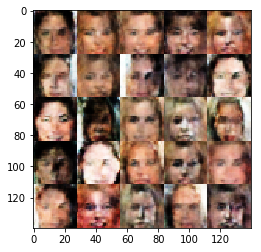

Epoch 1/1... Batch # 5100/1... Discriminator Loss: 1.2237... Generator Loss: 0.8986
Epoch 1/1... Batch # 5200/1... Discriminator Loss: 1.2017... Generator Loss: 1.0952
Epoch 1/1... Batch # 5300/1... Discriminator Loss: 1.2149... Generator Loss: 1.0976
Epoch 1/1... Batch # 5400/1... Discriminator Loss: 1.1511... Generator Loss: 1.0237
Epoch 1/1... Batch # 5500/1... Discriminator Loss: 1.1245... Generator Loss: 1.0594


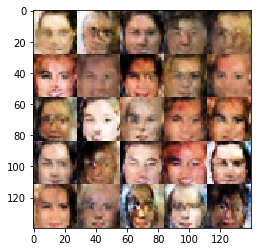

Epoch 1/1... Batch # 5600/1... Discriminator Loss: 1.1876... Generator Loss: 0.9984
Epoch 1/1... Batch # 5700/1... Discriminator Loss: 1.2084... Generator Loss: 0.9979
Epoch 1/1... Batch # 5800/1... Discriminator Loss: 1.2552... Generator Loss: 1.1096
Epoch 1/1... Batch # 5900/1... Discriminator Loss: 1.1499... Generator Loss: 1.0084
Epoch 1/1... Batch # 6000/1... Discriminator Loss: 1.1352... Generator Loss: 1.1314


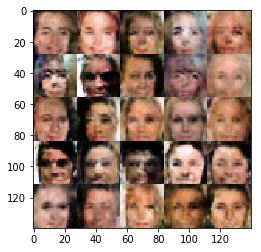

Epoch 1/1... Batch # 6100/1... Discriminator Loss: 1.1669... Generator Loss: 0.9321
Epoch 1/1... Batch # 6200/1... Discriminator Loss: 1.1421... Generator Loss: 1.0867
Epoch 1/1... Batch # 6300/1... Discriminator Loss: 1.1851... Generator Loss: 1.1171


In [15]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, print_every, show_every)

__Project notes:__ 

I have tried batch sizes of 16, 32, 64 and 128.  For smaller batches, the learning rate needs to be smaller too (as the gradients are more likely to go unstable).  Thanks to my reviewer for suggesting going as low as 16!

For learning rates, I went from 0.0002 to 0.0008.  Batch size 32 with a learning rate of 0.0005 seems to perform well for MNIST. However, for celebA, a smaller batch size (16), a smaller learning rate (0.0003) produces better images. d_loss was 1.34 and g_loss is 0.80.

Tried dropout.  For celebA, with batch_size = 16, lr=0.0002, dropout with keep_prob = 0.5 resulted in OK faces with d_loss=1.31 and g_loss =1.18. With keep_prob of 0.8, and a higher lr of 0.0003, we get to d_loss=1.35 and g_loss =0.80.  (32, 0.0003, 0.8) gives d-loss  = 1.17, g_loss =1.07

(16, 0.0003, 0.8) gives d-loss  = 1.67, g_loss = 0.71.  Despite the low generator loss, I find the figures not as good as the ones from before dropout, Xavier intialization and deeper generator were added. Will add dropout to generator as well. Also, I notice that while g_loss + d_loss is decreasing, each of these terms individually is not taking a steady path down.  I will cut the learning rate to see improvement in this regard.

I have also run this upto 50 epochs on AWS and that gave sharper and better outputs.  This is from the roughly 1 GB GPU that I have on my local machine.  For the project, we're looking at performance with just 1 epoch.  

Faces are recognizable in a single epoch.  I have tried beta1 values of 0.9, 0.5 and also lower values. 0.2 is good, as is 0.3.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.